In [1]:
######################################################### Imports #############################################################

import vrep
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [2]:
################################################## Conexão com o V-rep #######################################################

clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5) # Faz conexão, se retorna -1 é que deu erro

if clientID!=-1:
    print('Conexão sucedida')
else:
    print("Erro na conexão")

Conexão sucedida


In [3]:
################################################ Declaração de Váriáveis ######################################################
   
    # Função np.arrange dá sequenência de numeros, dado umintervalo
    # ctrl.Antecedent descrita na documentação do scikit-fuzzy,idem à  ctrl.Consequent
    
## Valores Crisp
sensores_handle = []        #lista com os Handles dos sensores, para pegar os Handles mais fácil
valores_sensores = [1,2,3,4,5]       # Lista com os valores dos sensores


# Valores Fuzzy
    # Antecedentes: Váriaveis à serem Fuzificada
sensor_frente = ctrl.Antecedent(np.arange(0, 0.12, 0.01), 'sensor_frente')
sensores_left  = ctrl.Antecedent(np.arange(0,0.12, 0.01), 'sensores_left')
sensores_right = ctrl.Antecedent(np.arange(0, 0.12, 0.01), 'sensores_right')

    # Consequentes
v_left = ctrl.Consequent(np.arange(0, 10, 0.5 ), 'v_left') # velocidade motor esquerdo, vai de 0 à 10 (eu determinei impiricamente na simulação)
v_right = ctrl.Consequent(np.arange(0, 10, 0.5), 'v_right') # idem ao de cima pro motor direit

In [4]:
############################################ Declaração de Handles ############################################################

# Não sei direito o que é um handle até hoje, mas chutaria que ele é uma coisa que controla o objeto real

#handle do motor esquerdo, chuto que o nome do objeto seja o mesmo da simulação
erro_code, leftMotorHandle = vrep.simxGetObjectHandle(clientID,'motorE', vrep.simx_opmode_oneshot_wait )
if erro_code != 0:
    print("handle nao encontrado")
else:
    print("Conectado ao motor esquerdo")
#Handle do motor Direito
erro_code, rightMotorHandle = vrep.simxGetObjectHandle(clientID,'motorD', vrep.simx_opmode_oneshot_wait )
if erro_code != 0:
    print("handle nao encontrado")
else:
    print("Conectado ao motor  direito")
    
#Handle dos sensores, só importam os do 1 ao 5, o 3 é o sensor mais centralizado
for i in range(5):
    erro_code, sensor_handle = vrep.simxGetObjectHandle(clientID,'KJunior_proxSensor%d' % (i+1) , vrep.simx_opmode_oneshot_wait)
    sensores_handle.append(sensor_handle)
    if erro_code != 0:
        print("handle do sensor %d não encontrado" %(i+1) )
    else:
        print("Conectado ao sensor %d " %(i+1) )
    
    # Não sei porque, mas a primeira leitura tem que ser assim
    error_code,estado,coord,detectedObjectHandle,detectedSurfaceNormalVector = vrep.simxReadProximitySensor(clientID, sensor_handle,vrep.simx_opmode_streaming)
    

Conectado ao motor esquerdo
Conectado ao motor  direito
Conectado ao sensor 1 
Conectado ao sensor 2 
Conectado ao sensor 3 
Conectado ao sensor 4 
Conectado ao sensor 5 


In [5]:
############################################# Lógica Fuzzy ################################################################

## Funções de pertinencia (Também conhecidas como membership)
    # Fuzz.trimf faz uma função de pertinencia triangulas onde [x,y,z] são os pontos do triangulo
    
# Sensor da frente
sensor_frente['perto'] = fuzz.trimf(sensor_frente.universe, [0, 0, 0.065])
sensor_frente['longe'] = fuzz.trimf(sensor_frente.universe,[0.065,0.065,0.12])
                             
# Sensor do lado esquerdo
sensores_left['perto'] = fuzz.trimf(sensores_left.universe, [0, 0, 0.065])
sensores_left['longe'] = fuzz.trimf(sensores_left.universe,[0.065,0.065,0.12])

# Sensores do lado direito
sensores_right['perto'] = fuzz.trimf(sensores_right.universe, [0, 0, 0.065])
sensores_right['longe'] = fuzz.trimf(sensores_right.universe,[0.065,0.065,0.12])

# Velocidade Motor esquerdo 
v_left['parado'] = fuzz.trimf(v_left.universe, [0, 0, 0.1])
v_left['lento'] = fuzz.trimf(v_left.universe, [1, 4, 10])
v_left['rapido'] = fuzz.trimf(v_left.universe, [5, 10, 10])


# Velocidade motor direito
v_right['parado'] = fuzz.trimf(v_right.universe, [0, 0, 0.1])
v_right['lento'] = fuzz.trimf(v_right.universe, [1, 4, 10])
v_right['rapido'] = fuzz.trimf(v_right.universe,  [5, 10, 10])

## Regras Fuzzy
rule1 = ctrl.Rule(sensor_frente['perto'] and sensores_left['perto'] and sensores_right['perto'], v_left['parado'] )
rule2 = ctrl.Rule(sensor_frente['longe'] and sensores_left['longe'] and sensores_right['longe'], v_left['rapido'] )
rule3 = ctrl.Rule(sensor_frente['perto'] and sensores_left['perto'] and sensores_right['longe'], v_left['rapido'] )

rule4 = ctrl.Rule(sensor_frente['perto'] and sensores_left['perto'] and sensores_right['perto'] , v_right['rapido'] )
rule5 = ctrl.Rule(sensor_frente['longe'] and sensores_left['longe'] and sensores_right['longe'], v_right['rapido'] )
rule6 = ctrl.Rule(sensor_frente['perto'] & sensores_left['perto'] & sensores_right['longe'], v_right['parado'] )
# tem um bug muito estranho na regra 6 que se colocar dois and dá erro, por isso o &

## Gráficos das funções de pertinência 


D:\Programas\Anaconda\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


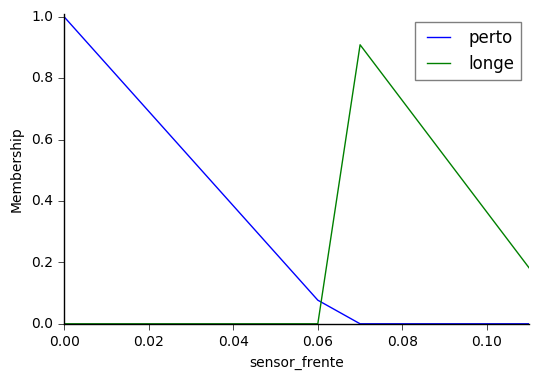

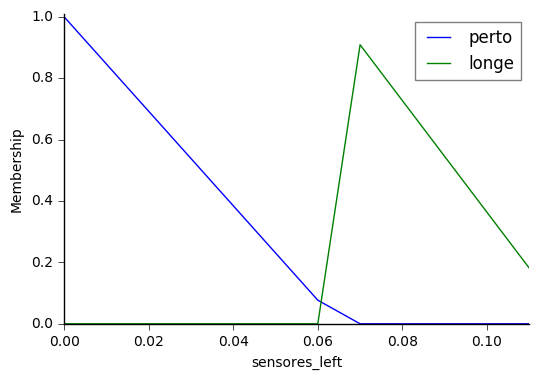

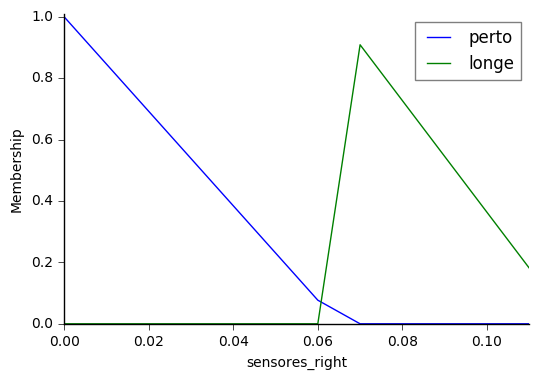

In [6]:
############################# INPUTS ################################

%matplotlib inline 
sensor_frente.view()
sensores_left.view()
sensores_right.view()

D:\Programas\Anaconda\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


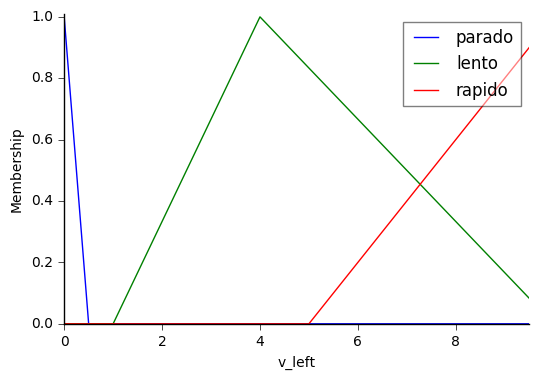

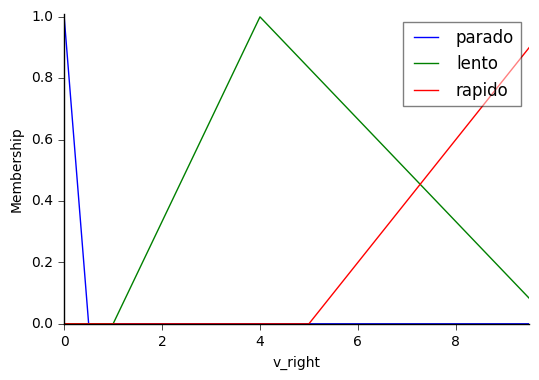

In [ ]:
####################################### Outputs ####################################################
%matplotlib inline 
v_left.view()
v_right.view()

In [ ]:
################################## controlando o Robô ##############################################################

while vrep.simxGetConnectionId(clientID != -1): #Enquanto houver conexão com o V-rep
    
    #Lê os sensores do robo e os coloca na lista de valores
    for i in range(5):
        error_code, estado, coord, detectedObjectHandle, detectedSurfaceNormalVector = vrep.simxReadProximitySensor(clientID,sensores_handle[i], vrep.simx_opmode_buffer)
        # Não sei pra que serve o estado, nem os dois últimos parametros retornados
        if estado !=0:
            valores_sensores[i] = coord[2] # pega apenas cordenada Z que é a que importe de verdade
        else:
            valores_sensores[i] = 0.8
        
        
        ### Sistema de controle fuzzy
        fuzzy_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5,rule6]) #sistema de controle
        kjunior = ctrl.ControlSystemSimulation(fuzzy_ctrl) #simulação do sistema de controle, pode-se criar vários para cada situação


        #Inputs para a simulação do K-junior
        kjunior.input['sensor_frente'] = (valores_sensores[0] + valores_sensores[1])/2 #media dos valores 
        kjunior.input['sensores_left'] = valores_sensores[2]
        kjunior.input['sensores_right'] = (valores_sensores[3] + valores_sensores[4])/2 # media dos valores

        ### Processando a simulação do controle
        kjunior.compute()

        vl = kjunior.output['v_left']         #Pega velocidade a ser passada para o motor direito
        vr = kjunior.output['v_right']        #Pega velocidade a ser passada para o motor esquerdo
    
    # Passando as velocidades para o K-junior
    
    #Motor Esquerdo
    erro_code = vrep.simxSetJointTargetVelocity(clientID, leftMotorHandle, vl, vrep.simx_opmode_streaming)
    if erro_code !=0:
        print("erro na atribuição de velocidade do motor esquerdo")
    
    #Motor Direito
    erro_code = vrep.simxSetJointTargetVelocity(clientID, rightMotorHandle, vr, vrep.simx_opmode_streaming)
    if erro_code !=0:
       print("erro na atribuição de velocidade do motor direito")
 

erro na atribuição de velocidade do motor esquerdo
erro na atribuição de velocidade do motor direito


# Teste apenas

### Sistema de controle fuzzy
fuzzy_ctrl = ctrl.ControlSystem([rule1, rule2, rule3,rule4,rule5,rule6]) #sistema de controle
kjunior = ctrl.ControlSystemSimulation(fuzzy_ctrl) #simulação do sistema de controle, pode-se criar vários para cada situação


#Inputs para a simulação do K-junior
kjunior.input['sensor_frente'] = 0.08
kjunior.input['sensores_left'] = 0.02
kjunior.input['sensores_right'] = 0.1

### Processando a simulação do controle
kjunior.compute()

vl = kjunior.output['v_left']         #Pega velocidade a ser passada para o motor direito
vr = kjunior.output['v_right']        #Pega velocidade a ser passada para o motor esquerdo

print (kjunior.output)